# **Распознавание речи**

В папке MNIST_9-25 находятся подпапки num0,num1,...,num9 c звуковыми файлами цифр 0,1,...,9. Файлы записывались сотрудниками лаборатории статистического анализа ВМК МГУ, знакомыми американцами и членам их семей, правда среди них были также китайцы и русские, так что некоторый акцент в произношении неизбежен. Из них было смоделировано случайным образом варианты из 300 телефонных номеров по 10 цифр каждый, цифры которого произносятся разными случайными спикерами.

In [1]:
!unzip -qq /content/MNIST_9-25-20231118T083117Z-001.zip

In [6]:
var = 4

In [2]:
!unzip -qq /content/4-20231118T184415Z-001.zip

In [3]:
!pip install pydub
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5872 sha256=578babf26ed0e50e9c7ed64b63c2d317faf58cc39e9edf5eca5cbd8f33c98089
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


**I have tried to run 'pip install hmmlearn' directly in the notebook cell. After that I restarted the kernel and it worked for me.**

In [4]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 3.3 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import warnings

import hmmlearn
from hmmlearn import hmm

from scipy.io import wavfile

from pydub import AudioSegment
from pydub.silence import split_on_silence

import librosa
import librosa.display
from python_speech_features import mfcc

Извлекаем признаки из кепстрального анализа

features_mfcc = mfcc(signal, sampling_freq, numcep=num_cep_coeff)

Параметры по умолчанию которой winlen=0.025, winstep=0.01, nfft=512 Это соответственно ширина окна в секундах, размер сдвига окна в секундах и количество частот для построения спектра мощности для текущего окна. Так как использется алгоритм быстрого преобразования Фурье, последнее число должно быть степенью двойки.

**Далее features_mmfc добавляются в массив X**

**После обхода всех файлов с текущей цифрой создается класс ModelHMM**

**model = ModelHMM(num_components=num_states),**

**где num_states - чмсло состояний скрытой цепи Маркова,**

**и происходит оценка параметров соответствующей скрытой цепи Маркова для всех полученых features из массива Х, также вычисляется максимальное достигнутое значение функции правдоподобия**

In [8]:
class ModelHMM(object):
    def __init__(self, num_components=8, num_iter=1000):
        self.n_components = num_components
        self.n_iter = num_iter
    # Define the covariance type and the type of HMM:
        self.cov_type = 'diag'
        self.model_name = 'GaussianHMM'
    # Initialize the variable in which we will store the models for each word:
        self.models = []
    # Define the model using the specified parameters:
        self.model = hmm.GaussianHMM(n_components=self.n_components,
                covariance_type=self.cov_type,n_iter=self.n_iter)

    # Define a method to train the model
    # 'training_data' is a 2D numpy array where each row has length of number of mfcc coefficients
    def train(self, training_data):
        np.seterr(all='ignore')
        cur_model = self.model.fit(training_data)
        self.models.append(cur_model)

    # Define a method to compute log likelihood score for input features
    def compute_score(self, input_data):
        return self.model.score(input_data)  # model.score returns log likelihood of sample input_data

In [9]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [48]:
def build_one_model(input_folder, num_states, num_cep_coeff):
    # input_folder: path to the folder containing training wav files with the word
    # num_states: number of hidden states in HMM
    # num_cep_coeff: number of MFCC features extracted from each time window

    X = np.array([])  # features
    training_files = [x for x in os.listdir(input_folder) if x.endswith('.wav')]
    for filename in training_files:
        # Extract the current filepath and read the file
        filepath = os.path.join(input_folder, filename)
        sampling_freq, signal = wavfile.read(filepath)
        sound = AudioSegment.from_file(filepath, format="wav")
        duration = len(sound)

        start_trim = detect_leading_silence(sound)
        end_trim = detect_leading_silence(sound.reverse())
        duration = len(sound)
        trimmed_sound = sound[start_trim:duration - end_trim]
        trimmed_sound.export("tmp.wav", format="wav")

        # Extract features
        # Default values:
        # winlen=0.025, winstep=0.01, nfft=512,
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            features_mfcc = mfcc(signal, sampling_freq, numcep=num_cep_coeff)

        # Append features to the variable X
        if len(X) == 0:
            X = features_mfcc
        else:
            X = np.append(X, features_mfcc, axis=0)

    # Initiate HMM model object
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        model = ModelHMM(num_components=num_states)

    # Train HMM model, calculate likelihood of the sample by the trained model
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        model.train(X)
        model_score = model.compute_score(X)

    return model, model_score, num_cep_coeff

Параметр numcep - это число кепстральных коэффициентов, которое вычисляется для каждого положения окна внутри сигнала. Вспомнить, что делает эта функция поможет шайни https://shiny.ilykei.com/ANDoynikov/cepstrum/ , которую Вы уже видели в весеннем семестре.

In [54]:
def build_models(input_folder):
    # input_folder contains subfolders with samples of words in wav files
    # Initialize the variable to store all the models

    speech_models = []

    # Parse the input directory
    for dirname in os.listdir(input_folder):

        # Get name of subfolder
        subfolder = os.path.join(input_folder, dirname)

        if not os.path.isdir(subfolder) or subfolder == "./MNIST_9-25/.ipynb_checkpoints":
          continue

        # Extract label
        label = subfolder[subfolder.rfind('/') + 1:]

        # Fit model for label
        best_score = -float('inf')
        for num_components in range (10, 30, 5):
          for num_cepstr in range (10, 30, 5):
            model = build_one_model(subfolder, num_states=num_components, num_cep_coeff=num_cepstr)
            if model[1] > best_score:
              best_model = model
              best_score = model[1]

        # Add the model to the list
        speech_models.append((best_model, label))

        # Reset model variable
        model = None

    return speech_models

Запускаем обучение и построение модели с перебором гиперпараметров по сетке

In [55]:
models = build_models("./MNIST_9-25")

### Распознавание цифр телефона по предобученной модели

Тепрь нужно разделить каждый сигнал на 10 фрагментов (по условию телефонный номер состоит из 10 цифр)

In [26]:
def ten_audio_chunks(cur_wavfile):
  sound_file = AudioSegment.from_wav(cur_wavfile)
  for silence_len in range (10, 150, 10):
    for thresh in range (-50, 0, 5):
      audio_chunks = split_on_silence(sound_file, min_silence_len=silence_len, silence_thresh=thresh)
      if (10 == len(audio_chunks)):
        return audio_chunks
  print('ERROR IN PARTITION TO 10 AUDIO_CHUNKS ' + cur_wavfile)

silence_len - длина паузы в милисекундах между цифрами в записи телефона

thresh - уровень шума между цифрами в децибелах.

**Пороги для них подбирались исходя из данных. Если не получилось разделить на 10 фрагментов, я смотрел отдельно на неудавшийся для разбиения файл (показано ниже) и менял границы цикла.**

In [27]:
chunks = []
for i in range(300):
  cur_wavfile = f'./{var}/{i}.wav'
  chunks.append(ten_audio_chunks(cur_wavfile))

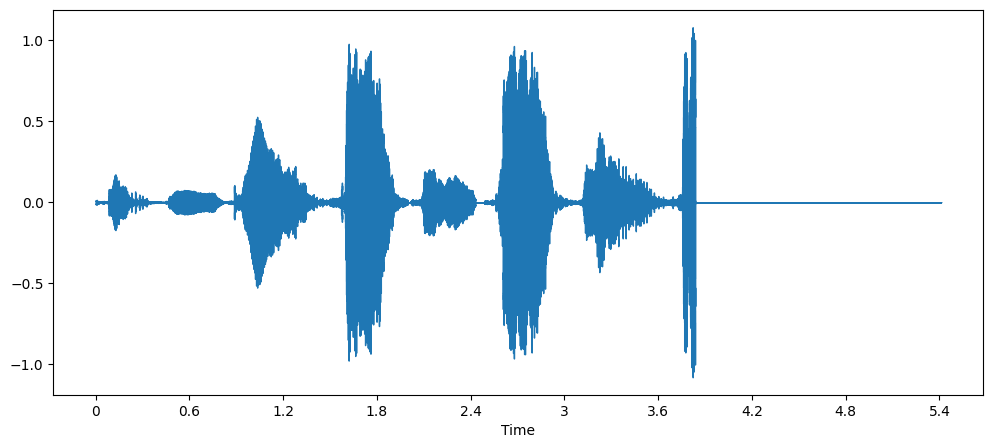

Signal rate=  22050


In [24]:
cur_wavfile = f'./{var}/117.wav'
x, sr = librosa.load(cur_wavfile)

# Plot the sample.
plt.figure(figsize=(12, 5))
librosa.display.waveshow(x, sr=sr)
plt.show()
print("Signal rate= ",sr)

Вот здесь, например, какой-то странный человек говорил цифры очень быстро

Далее функция word_score, которая вычисляет логарифм правдоподобия:

In [56]:
def score_one_word(trained_model, test_file_path):
    # trained_model: ModelHMM object with trained model
    # test_file_path: path to wav file

    sampling_freq, signal = wavfile.read(test_file_path)
    num_cep_coeff = trained_model[2]

    # Extract features
    # Default values:
    # winlen=0.025, winstep=0.01, nfilt=26, nfft=512,
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        features_mfcc = mfcc(signal, sampling_freq, numcep=num_cep_coeff)

        # Calculate log likelihood
        word_score = trained_model[0].compute_score(features_mfcc)
    return word_score

Эта функция в свою очередь вызывается в цикле по моделям всех цифр от 0 до 9. Выбирается та цифра, где логарифм функции правдоподобия максимальный. Это переменная predicted_label

In [57]:
def predict_number(chunks, speech_models):
  ans = ''
  for chunk in chunks:
    tmp_filename = 'tmp.wav'
    chunk.export(tmp_filename, format="wav")
    max_score = -float('inf')

    # Run the current feature vector through all the HMM
    #  models and pick the one with the highest score
    for item in speech_models:
      model, label = item
      score = score_one_word(model, tmp_filename)
      if score > max_score:
        predicted_label = label #label which has highest score
        max_score = score

    ans += predicted_label[3] #[3] for tmpX -> X
  return ans

В результате мы получим полностью номер телефона. Например, '0123439516'.

Мы готовы определить все произнесенные 300 номеров телефона.

In [58]:
predictions = []
for i in range(300):
  predictions.append(predict_number(chunks[i], models))

Из полученных номеров телефонов создается массив, который сохраняется в файл результатов в формате. Имя столбца не указывается.

0,3459986127

1,2335530968

2,9540596584

3,2871961713

......

298,9341169408

299,7697136246

In [59]:
df = pd.DataFrame(predictions)
df.to_csv('submission.csv', header=False)